# Clean notebook for Encointer PoP protocol analysis

In [10]:
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import math

## Using the hypergeometric distribution (tail bounds)

In [11]:
def upper_proba_k(k=3, sybil_fraction=0.1, n_participants=1000):
    n_meetups = math.ceil(n_participants/12)
    meetup_size = math.floor(n_participants/n_meetups)
    t = math.ceil(k/meetup_size) - sybil_fraction
    return math.exp(-2*meetup_size*t**2)

In [12]:
def get_proba_control(sybil_fraction=0.1, n_legitimates=1000):
    n_sybils = math.ceil(sybil_fraction*n_legitimates / (100-sybil_fraction))
    n_participants = n_sybils + n_legitimates
    n_meetups = math.ceil(n_participants/12)
    k = math.ceil((3/4) * (n_participants/n_meetups)) -2
    return upper_proba_k(k=k, sybil_fraction=sybil_fraction, n_participants=n_participants)

In [13]:
def get_proba_sabotage(sybil_fraction=0.1, n_legitimates=1000):
    n_sybils = math.ceil(sybil_fraction*n_legitimates / (100-sybil_fraction))
    n_participants = n_sybils + n_legitimates
    return upper_proba_k(k=3, sybil_fraction=sybil_fraction, n_participants=n_participants)

## Plots of probability to sabotage/control a meetup and corresponding expected values

### Upper bound on proba of sabotage when fixed nb legitimates = 1000

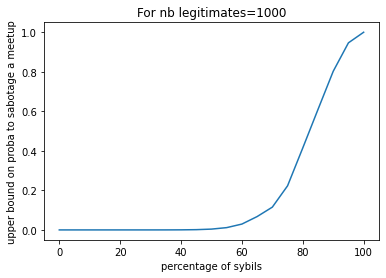

In [14]:
x = np.arange(0,1.05,0.05)
y = [0.0 for _ in range(len(x))]
for i,f in enumerate(x):
    y[i] = get_proba_sabotage(sybil_fraction=f,n_legitimates=1000)
plt.title("For 1000 legitimates")
plt.xlabel("percentage of sybils")
plt.ylabel("upper bound on proba to sabotage a meetup")
plt.plot(x*100,y)
#plt.savefig('proba_sabotage.png',dpi=250)

### Upper bound on proba of control when fixed nb legitimates = 1000

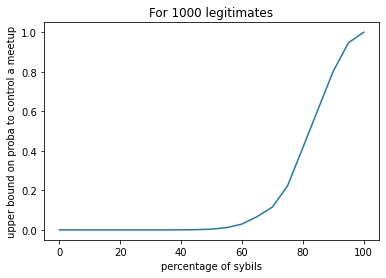

In [15]:
x = np.arange(0,1.05,0.05)
y = [0.0 for _ in range(len(x))]
for i,f in enumerate(x):
    y[i] = get_proba_control(sybil_fraction=f,n_legitimates=1000)
plt.title("For 1000 legitimates")
plt.xlabel("percentage of sybils")
plt.ylabel("upper bound on proba to control a meetup")
plt.plot(x*100,y)
plt.savefig('proba_control.png',dpi=250)

## Plot of expected profit for a ceremony

### Minimum expected profit over all meetups
Using linearity of expectation

In [21]:
def expected_profit(sybil_fraction,n_legitimates,reward,friction):
    n_sybils = math.ceil(sybil_fraction*n_legitimates / (100-sybil_fraction))
    n_participants = n_sybils + n_legitimates
    n_meetups = math.ceil(n_participants/12)
    k = math.ceil((3/4) * (n_participants/n_meetups)) -2
    min_profit = reward*k
    additional_sybil_cost = friction*reward
    max_cost = (k-1)*additional_sybil_cost
    p = get_proba_control(sybil_fraction=sybil_fraction,n_legitimates=n_legitimates)
    return (min_profit*p - max_cost*(1-p)) * n_meetups

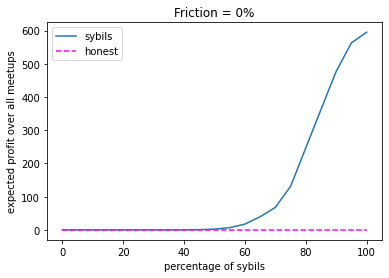

In [25]:
reward = 1
friction = 0
n_legitimates = 1000

x = np.arange(0,1.05,0.05)
y = [0.0 for _ in range(len(x))]

for i,f in enumerate(x):
    y[i] = expected_profit(f,n_legitimates,reward,friction)
    
plt.title("Friction = 0%")
plt.xlabel("percentage of sybils")
plt.ylabel("expected profit over all meetups")
plt.plot(x*100,y)
plt.plot(x*100,[1]*len(y), color = 'fuchsia', linestyle='--')

plt.legend(["sybils","honest"])
plt.savefig('min_profit_all_meetups.png',dpi=250)

## Plot initial investment to get a given percentage of sybils, as well as corresponding number of ceremonies

In [26]:
# investment to get a given fraction of sybils in the network
def initial_investment(sybil_fraction, n_legitimates, reward, friction):       
    n_previous_participants = n_legitimates
    n_sybils = math.floor(n_previous_participants/3)
    if (sybil_fraction==0):
        n_sybils = 0
    investment = []
    additional_sybil_cost = friction*reward
    
    prev_inv = n_sybils*additional_sybil_cost-reward
    investment.append(prev_inv)
    n_previous_participants += n_sybils
    curr_sybil_fraction = n_sybils/n_previous_participants
        
    while curr_sybil_fraction < sybil_fraction:
        add_sybils = math.floor(n_previous_participants/3)
        n_sybils += add_sybils
        n_previous_participants += add_sybils
        profit = expected_profit(curr_sybil_fraction,n_legitimates,reward,additional_sybil_cost) + reward
        prev_inv = prev_inv+add_sybils*additional_sybil_cost - profit
        investment.append(prev_inv)
        curr_sybil_fraction = n_sybils/n_previous_participants
            
    return investment, len(investment)

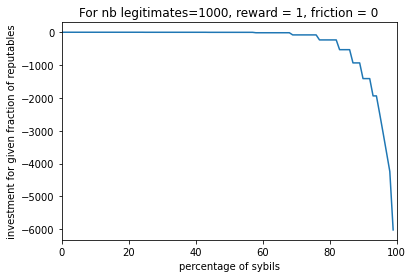

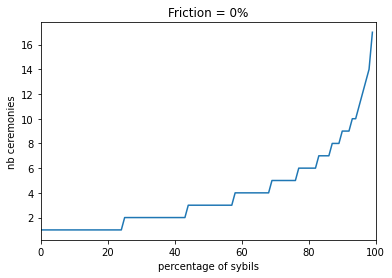

In [29]:
reward = 1
friction =  0
sybil_fraction = np.arange(0,1.0,0.01)
investment = [0.0 for _ in range(len(sybil_fraction))]
ceremonies = [0 for _ in range(len(sybil_fraction))]
for idx,f in enumerate(sybil_fraction):
    inv, n_cerem = initial_investment(f,1000, reward, friction)
    if (len(inv)>0):
        investment[idx] = inv[-1]
    ceremonies[idx] = n_cerem
plt.title("For nb legitimates=1000, reward = 1, friction = 0")
plt.xlabel("percentage of sybils")
plt.ylabel("investment for given fraction of reputables")
plt.xlim(0,100)
plt.plot(sybil_fraction*100,investment)
#plt.savefig('investment_for_reputation.png',dpi=250)
plt.show()
plt.title("Friction = 0%")
plt.xlabel("percentage of sybils")
plt.ylabel("nb ceremonies")
plt.xlim(0,100)
plt.plot(sybil_fraction*100,ceremonies)
plt.savefig('ceremonies_for_reputation.png',dpi=250)
plt.show()

The above graph corresponds to the initial investment before having a chance of making profit.

## Plot profit cumulated over several ceremonies depending on sybils percentage for a 0% friction

Attacker invest until having 'sybil_fraction' fraction of sybils then maintain these sybils.

In [30]:
def cum_profit(sybil_fraction,n_legitimates,reward,friction,total_n_ceremonies):
    inv,n_init_cerem = initial_investment(sybil_fraction,n_legitimates,reward,friction)
    profit = [i * (-1) for i in inv]
    lasting_ceremonies = total_n_ceremonies - n_init_cerem
    new_profit = 0
    if (n_init_cerem>0):
        new_profit = profit[-1]

    n_sybils = math.ceil(sybil_fraction*n_legitimates / (100-sybil_fraction))
    n_participants = n_sybils + n_legitimates
    n_meetups = math.ceil(n_participants/12)
    k = math.ceil((3/4) * (n_participants/n_meetups)) -2
    p = get_proba_control(sybil_fraction,n_legitimates=1000)

    for _ in range(lasting_ceremonies):
        new_profit += reward+expected_profit(sybil_fraction,n_legitimates,reward,friction)
        profit.append(new_profit)
        
    return profit

There are ceremonies every 41 days so there are about 9 ceremonies per year. This means x ceremonies is equivalent to x/9 years.

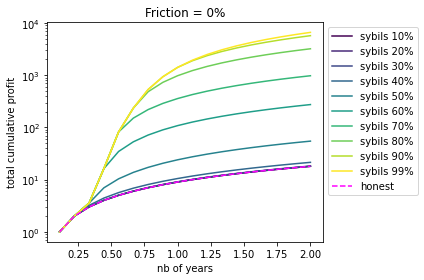

In [31]:
reward = 1
friction = 0
total_n_ceremonies = 18 #warning: nb of ceremonies must be enough to get 99% otherwise last plot on 'sybils 99%' fails
n_legitimates=1000


plt.title("Friction = 0%")
plt.xlabel("nb of years")
plt.ylabel("total cumulative profit")
ceremonies = range(1,total_n_ceremonies+1)
years = list(map(lambda c: c/9, ceremonies))
viridis = cm.get_cmap('viridis', 10).colors
plt.plot(years,cum_profit(0.10,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[0], label="sybils 10%")
plt.plot(years,cum_profit(0.20,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[1], label="sybils 20%")
plt.plot(years,cum_profit(0.30,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[2], label="sybils 30%")
plt.plot(years,cum_profit(0.40,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[3], label="sybils 40%")
plt.plot(years,cum_profit(0.50,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[4], label="sybils 50%")
plt.plot(years,cum_profit(0.60,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[5], label="sybils 60%")
plt.plot(years,cum_profit(0.70,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[6], label="sybils 70%")
plt.plot(years,cum_profit(0.80,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[7], label="sybils 80%")
plt.plot(years,cum_profit(0.90,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[8], label="sybils 90%")
plt.plot(years,cum_profit(0.99,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[9], label="sybils 99%")
plt.plot(years, ceremonies, color = 'fuchsia', linestyle='--', label="honest")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#plt.xlim(0,20)
#plt.ylim(0,50)
plt.tight_layout()
plt.savefig('cumulative_profit_no_friction.png',dpi=250)

For a scenario with no friction between the ceremony reward and the price of a sybil: <br>
Profit the adversary makes for different values of sybil percentage in the network, increasing with the number of years. <br>
From 10% to 30%, the profit is about that of an honest participant, for 40% it is higher but still close, for 50% and more it is clearly greater.

### Plot cumulative profit depending on sybils percentage for fixed nb of ceremonies

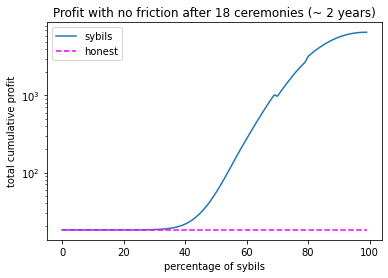

In [32]:
reward = 1
friction = 0
total_n_ceremonies = 18
n_legitimates=1000
sybil_fraction = np.arange(0,1.0,0.01)
cumulative_profit = []
for f in sybil_fraction:
    cumulative_profit.append(cum_profit(f,n_legitimates, reward, friction, total_n_ceremonies)[-1])
    
plt.title("Profit with no friction after 18 ceremonies (~ 2 years)")
plt.xlabel("percentage of sybils")
plt.ylabel("total cumulative profit")
plt.plot(sybil_fraction*100,cumulative_profit)
plt.plot(sybil_fraction*100,[total_n_ceremonies]*len(cumulative_profit), color = 'fuchsia', linestyle='--')
plt.yscale('log')

plt.legend(["sybils","honest"])
plt.savefig('profitVSfraction.png',dpi=250)

Still in the scenario with no friction, we plot the profit made after 16 ceremonies, which is equivalent to about 22 months. <br>
Above 40% starts to get much profitable for the adversary.

## Adding the non-null friction constraint

The friction is the percentage of the reward that needs to be additionally paid by the adversary to their sybils (=minions).

In [39]:
# We focus on 0.1%, 1%, 10% and 100% frictions
frictions_of_interest = np.array([0.001, 0.01, 0.1, 1])

### Plot expected profit for all meetups of a ceremony

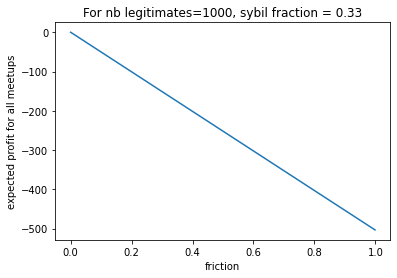

In [17]:
reward = 1
sybil_fraction = 0.33
n_legitimates = 1000
frictions = np.arange(0,1,0.001)

y = [0.0 for _ in range(len(frictions))]

for i,f in enumerate(frictions):
    y[i] = expected_profit(sybil_fraction,n_legitimates,reward,f)
    
plt.title("For nb legitimates=1000, sybil fraction = 0.33")
plt.xlabel("friction")
plt.ylabel("expected profit for all meetups")
plt.plot(frictions,y)
#plt.savefig('min_profit_all_meetups_friction_33.png',dpi=250)

### Plot initial investment for getting a given sybil percentage

In [33]:
def get_investment(sybil_fraction, frictions):
    reward = 1
    n_legitimates=1000
    investment = []
    
    for f in frictions:
        inv,_ = initial_investment(sybil_fraction,n_legitimates, reward, f)
        if (len(inv)>0):
            investment.append(inv[-1])
        else:
            investment.append(0)
    return investment

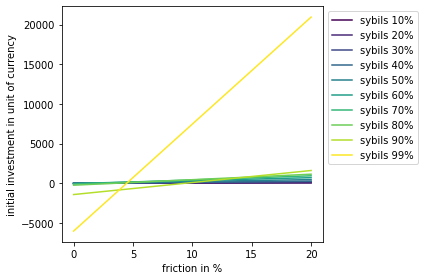

In [34]:
frictions_bis = np.arange(0,0.201,0.001)
plt.xlabel("friction in %")
plt.ylabel("initial investment in unit of currency")
viridis = cm.get_cmap('viridis', 10).colors
plt.plot(frictions_bis*100,get_investment(0.10, frictions_bis), color=viridis[0], label="sybils 10%")
plt.plot(frictions_bis*100,get_investment(0.20, frictions_bis), color=viridis[1], label="sybils 20%")
plt.plot(frictions_bis*100,get_investment(0.30, frictions_bis), color=viridis[2], label="sybils 30%")
plt.plot(frictions_bis*100,get_investment(0.40, frictions_bis), color=viridis[3], label="sybils 40%")
plt.plot(frictions_bis*100,get_investment(0.50, frictions_bis), color=viridis[4], label="sybils 50%")
plt.plot(frictions_bis*100,get_investment(0.60, frictions_bis), color=viridis[5], label="sybils 60%")
plt.plot(frictions_bis*100,get_investment(0.70, frictions_bis), color=viridis[6], label="sybils 70%")
plt.plot(frictions_bis*100,get_investment(0.80, frictions_bis), color=viridis[7], label="sybils 80%")
plt.plot(frictions_bis*100,get_investment(0.90, frictions_bis), color=viridis[8], label="sybils 90%")
plt.plot(frictions_bis*100,get_investment(0.99, frictions_bis), color=viridis[9], label="sybils 99%")

#plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")

#plt.xlim(0,1)
#plt.ylim(0,10)
plt.tight_layout()
plt.savefig('investment_friction.png',dpi=250)

### Plot cumulative profit for varying frictions for fixed number of ceremonies

In [35]:
def friction_vs_profit(sybil_fraction,n_legitimates,reward,total_n_ceremonies,frictions):
    profit = []
    
    for f in frictions:
        inv,n_init_cerem = initial_investment(sybil_fraction,n_legitimates,reward,f)
        if (len(inv)>0):
            investment = inv[-1]
        lasting_cerem = total_n_ceremonies-n_init_cerem
        if lasting_cerem <0:
            lasting_cerem = 0
        profit.append(lasting_cerem*(expected_profit(sybil_fraction,n_legitimates,reward,f)+reward)-investment)
        
    return np.array(profit)

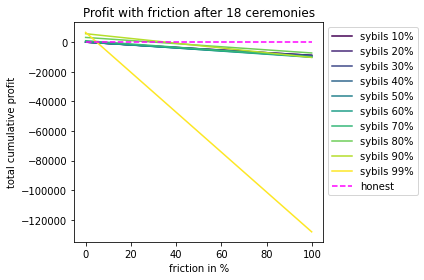

In [36]:
reward = 1
total_n_ceremonies = 18
n_legitimates=1000

frictions = np.arange(0,1,0.001)

plt.title("Profit with friction after 18 ceremonies")
plt.xlabel("friction in %")
plt.ylabel("total cumulative profit")
honest = [100]*len(frictions)
viridis = cm.get_cmap('viridis', 10).colors
plt.plot(frictions*100,friction_vs_profit(0.10,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[0], label="sybils 10%")
plt.plot(frictions*100,friction_vs_profit(0.20,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[1], label="sybils 20%")
plt.plot(frictions*100,friction_vs_profit(0.30,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[2], label="sybils 30%")
plt.plot(frictions*100,friction_vs_profit(0.40,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[3], label="sybils 40%")
plt.plot(frictions*100,friction_vs_profit(0.50,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[4], label="sybils 50%")
plt.plot(frictions*100,friction_vs_profit(0.60,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[5], label="sybils 60%")
plt.plot(frictions*100,friction_vs_profit(0.70,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[6], label="sybils 70%")
plt.plot(frictions*100,friction_vs_profit(0.80,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[7], label="sybils 80%")
plt.plot(frictions*100,friction_vs_profit(0.90,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[8], label="sybils 90%")
plt.plot(frictions*100,friction_vs_profit(0.99,n_legitimates,reward,total_n_ceremonies,frictions), color=viridis[9], label="sybils 99%")
plt.plot(frictions*100,honest,color = 'fuchsia', linestyle='--', label="honest")

#plt.yscale('log')

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#plt.xlim(0,1)
#plt.ylim(0,1000)
plt.tight_layout()
#plt.savefig('cumulative_profit_friction.png',dpi=250)

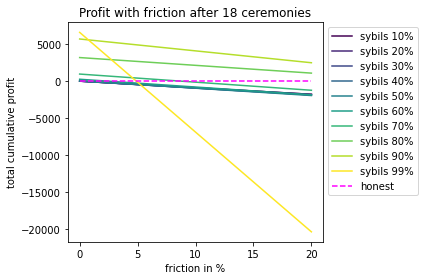

In [37]:
reward = 1
total_n_ceremonies = 18
n_legitimates=1000

frictions_bis = np.arange(0,0.201,0.001)

plt.title("Profit with friction after 18 ceremonies")
plt.xlabel("friction in %")
plt.ylabel("total cumulative profit")
honest = [100]*len(frictions_bis)
viridis = cm.get_cmap('viridis', 10).colors
plt.plot(frictions_bis*100,friction_vs_profit(0.10,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[0], label="sybils 10%")
plt.plot(frictions_bis*100,friction_vs_profit(0.20,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[1], label="sybils 20%")
plt.plot(frictions_bis*100,friction_vs_profit(0.30,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[2], label="sybils 30%")
plt.plot(frictions_bis*100,friction_vs_profit(0.40,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[3], label="sybils 40%")
plt.plot(frictions_bis*100,friction_vs_profit(0.50,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[4], label="sybils 50%")
plt.plot(frictions_bis*100,friction_vs_profit(0.60,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[5], label="sybils 60%")
plt.plot(frictions_bis*100,friction_vs_profit(0.70,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[6], label="sybils 70%")
plt.plot(frictions_bis*100,friction_vs_profit(0.80,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[7], label="sybils 80%")
plt.plot(frictions_bis*100,friction_vs_profit(0.90,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[8], label="sybils 90%")
plt.plot(frictions_bis*100,friction_vs_profit(0.99,n_legitimates,reward,total_n_ceremonies,frictions_bis), color=viridis[9], label="sybils 99%")
plt.plot(frictions_bis*100,honest,color = 'fuchsia', linestyle='--', label="honest")

#plt.yscale('log')

plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#plt.xlim(0,1)
#plt.ylim(0,1000)
plt.tight_layout()
plt.savefig('cumulative_profit_friction_zoom.png',dpi=250)

## We fix different frictions to see the evolution of profit wrt percentages of sybils

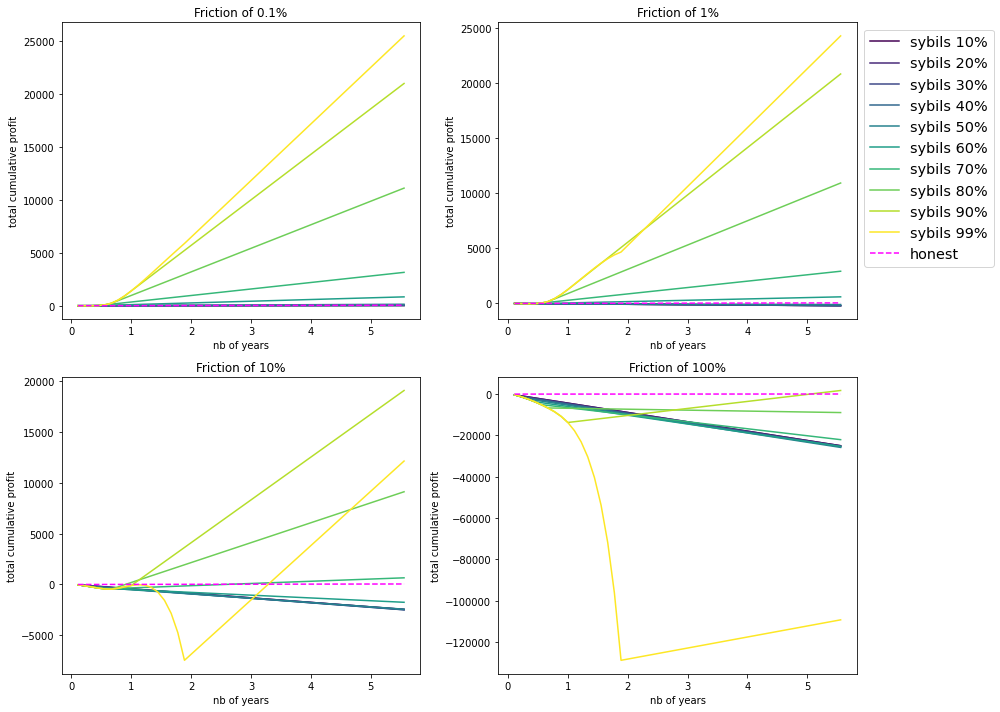

In [38]:
reward = 1
friction = 0.001
total_n_ceremonies = 50 #warning: nb of ceremonies must be enough to get 99% otherwise last plot on 'sybils 99%' fails
n_legitimates=1000

fig = plt.figure(figsize = (14,10))

ceremonies = range(1,total_n_ceremonies+1)
years = list(map(lambda c: c/9, ceremonies))
viridis = cm.get_cmap('viridis', 10).colors

plt.subplot(221)
plt.title("Friction of 0.1%")
plt.xlabel("nb of years")
plt.ylabel("total cumulative profit")

plt.plot(years,cum_profit(0.10,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[0], label="sybils 10%")
plt.plot(years,cum_profit(0.20,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[1], label="sybils 20%")
plt.plot(years,cum_profit(0.30,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[2], label="sybils 30%")
plt.plot(years,cum_profit(0.40,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[3], label="sybils 40%")
plt.plot(years,cum_profit(0.50,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[4], label="sybils 50%")
plt.plot(years,cum_profit(0.60,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[5], label="sybils 60%")
plt.plot(years,cum_profit(0.70,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[6], label="sybils 70%")
plt.plot(years,cum_profit(0.80,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[7], label="sybils 80%")
plt.plot(years,cum_profit(0.90,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[8], label="sybils 90%")
plt.plot(years,cum_profit(0.99,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[9], label="sybils 99%")
plt.plot(years, ceremonies, color = 'fuchsia', linestyle='--', label="honest")
#plt.yscale('log')

friction = 0.01
plt.subplot(222)
plt.title("Friction of 1%")
plt.xlabel("nb of years")
plt.ylabel("total cumulative profit")

plt.plot(years,cum_profit(0.10,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[0], label="sybils 10%")
plt.plot(years,cum_profit(0.20,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[1], label="sybils 20%")
plt.plot(years,cum_profit(0.30,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[2], label="sybils 30%")
plt.plot(years,cum_profit(0.40,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[3], label="sybils 40%")
plt.plot(years,cum_profit(0.50,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[4], label="sybils 50%")
plt.plot(years,cum_profit(0.60,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[5], label="sybils 60%")
plt.plot(years,cum_profit(0.70,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[6], label="sybils 70%")
plt.plot(years,cum_profit(0.80,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[7], label="sybils 80%")
plt.plot(years,cum_profit(0.90,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[8], label="sybils 90%")
plt.plot(years,cum_profit(0.99,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[9], label="sybils 99%")
plt.plot(years, ceremonies, color = 'fuchsia', linestyle='--', label="honest")
#plt.yscale('log')

plt.legend(bbox_to_anchor=(1,1), loc="upper left", fontsize= 'x-large')

friction = 0.1
plt.subplot(223)
plt.title("Friction of 10%")
plt.xlabel("nb of years")
plt.ylabel("total cumulative profit")

plt.plot(years,cum_profit(0.10,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[0], label="sybils 10%")
plt.plot(years,cum_profit(0.20,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[1], label="sybils 20%")
plt.plot(years,cum_profit(0.30,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[2], label="sybils 30%")
plt.plot(years,cum_profit(0.40,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[3], label="sybils 40%")
plt.plot(years,cum_profit(0.50,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[4], label="sybils 50%")
plt.plot(years,cum_profit(0.60,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[5], label="sybils 60%")
plt.plot(years,cum_profit(0.70,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[6], label="sybils 70%")
plt.plot(years,cum_profit(0.80,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[7], label="sybils 80%")
plt.plot(years,cum_profit(0.90,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[8], label="sybils 90%")
plt.plot(years,cum_profit(0.99,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[9], label="sybils 99%")
plt.plot(years, ceremonies, color = 'fuchsia', linestyle='--', label="honest")
#plt.yscale('log')

friction = 1
plt.subplot(224)
plt.title("Friction of 100%")
plt.xlabel("nb of years")
plt.ylabel("total cumulative profit")

plt.plot(years,cum_profit(0.10,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[0], label="sybils 10%")
plt.plot(years,cum_profit(0.20,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[1], label="sybils 20%")
plt.plot(years,cum_profit(0.30,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[2], label="sybils 30%")
plt.plot(years,cum_profit(0.40,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[3], label="sybils 40%")
plt.plot(years,cum_profit(0.50,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[4], label="sybils 50%")
plt.plot(years,cum_profit(0.60,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[5], label="sybils 60%")
plt.plot(years,cum_profit(0.70,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[6], label="sybils 70%")
plt.plot(years,cum_profit(0.80,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[7], label="sybils 80%")
plt.plot(years,cum_profit(0.90,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[8], label="sybils 90%")
plt.plot(years,cum_profit(0.99,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[9], label="sybils 99%")
plt.plot(years, ceremonies, color = 'fuchsia', linestyle='--', label="honest")
#plt.yscale('log')

#plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#plt.xlim(0,20)
#plt.ylim(0,50)

plt.tight_layout()
plt.savefig('cumulative_profit_diff_frictions.png',dpi=250)

### Plot max friction before getting negative profit for varying sybil percentages and fixed number of ceremonies

In [39]:
#plot fraction of sybils as a function of max friction before negative profit
total_n_ceremonies = 18
fractions = np.linspace(0,1,100)
max_frictions = []
profit = 0
investment = 0
f = 0
reward = 1
n_legitimates = 1000
for fraction in fractions:
    while profit>=0:
        f+=0.001
        inv,n_init_cerem = initial_investment(fraction,n_legitimates,reward,f)
        if (len(inv)>0):
            investment = inv[-1]
        else:
            investment = 0
        lasting_cerem = total_n_ceremonies-n_init_cerem
        if lasting_cerem <0:
            lasting_cerem = 0
        profit = lasting_cerem*(expected_profit(fraction,n_legitimates,reward,f)+reward)-investment
    max_frictions.append(f-0.0001) 
    profit = 0
    f = 0

### The higher the nb of ceremonies, the more time given to the adversary to make positive profit, and so the higher the maximum friction threshold. <br>
Since the adversary does not have infinite time and might not want to wait too many years to make profit, we can estimate a maximum nb of years the adversary would be willing to spend waiting for profit (while maintaining their sybils at a cost) and consider the corresponding max friction thresholds.

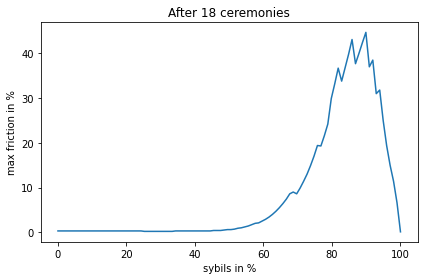

In [41]:
plt.title("After 18 ceremonies")
plt.xlabel("sybils in %")
plt.ylabel("max friction in %")
plt.plot(fractions*100, np.array(max_frictions)*100)
plt.tight_layout()
plt.savefig('fractionVSfriction.png',dpi=250)

We observe a drop after about 90%, probably due to the substantial initial investment.

In [42]:
result = np.where(max_frictions == np.amax(max_frictions))
max_friction_idx = result[0][0]
max_friction_fraction = fractions[max_friction_idx]
print("Sybil fraction with the highest 'max friction' threshold (before negative profit):")
print(max_friction_fraction)
print("Corresponding 'max friction':")
print(max_frictions[max_friction_idx])

Sybil fraction with the highest 'max friction' threshold (before negative profit):
0.8989898989898991
Corresponding 'max friction':
0.44690000000000035


For 45 ceremonies === about 5 years: <br>
The percentage of sybils that needs the highest friction to become uninteresting is 90%. <br>
The corresponding max friction at which the profit is non negative is 1.197. 

### Plot profit vs years with fixed (non null) friction

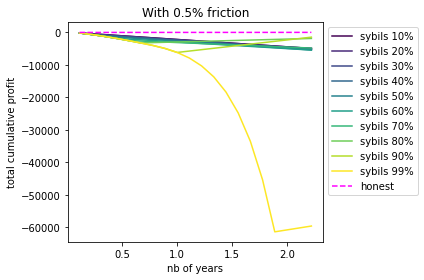

In [43]:
reward = 1
friction = 0.5
total_n_ceremonies = 20
n_legitimates=1000


plt.title("With 0.5% friction")
plt.xlabel("nb of years")
plt.ylabel("total cumulative profit")
ceremonies = range(1,total_n_ceremonies+1)
years = list(map(lambda c: c/9, ceremonies))
viridis = cm.get_cmap('viridis', 10).colors
plt.plot(years,cum_profit(0.10,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[0], label="sybils 10%")
plt.plot(years,cum_profit(0.20,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[1], label="sybils 20%")
plt.plot(years,cum_profit(0.30,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[2], label="sybils 30%")
plt.plot(years,cum_profit(0.40,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[3], label="sybils 40%")
plt.plot(years,cum_profit(0.50,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[4], label="sybils 50%")
plt.plot(years,cum_profit(0.60,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[5], label="sybils 60%")
plt.plot(years,cum_profit(0.70,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[6], label="sybils 70%")
plt.plot(years,cum_profit(0.80,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[7], label="sybils 80%")
plt.plot(years,cum_profit(0.90,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[8], label="sybils 90%")
plt.plot(years,cum_profit(0.99,n_legitimates, reward, friction, total_n_ceremonies), color=viridis[9], label="sybils 99%")
plt.plot(years, ceremonies, color = 'fuchsia', linestyle='--', label="honest")
#plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#plt.xlim(0,20)
#plt.ylim(0,50)
plt.tight_layout()
#plt.savefig('cumulative_profit_friction_years.png',dpi=250)


In [78]:
# TODO: re run notebook, check frictions values, make sure everything is correct and coherent

In [81]:
# TODO: write (english) results analysis and lessons

In [80]:
# TODO: write report